In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dont-overfit-ii/sample_submission.csv
/kaggle/input/dont-overfit-ii/train.csv
/kaggle/input/dont-overfit-ii/test.csv


In [74]:
! ls ../input/dont-overfit-ii

sample_submission.csv  test.csv  train.csv


In [75]:
train = pd.read_csv("../input/dont-overfit-ii/train.csv")
test = pd.read_csv("../input/dont-overfit-ii/test.csv")

In [76]:
train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


## EDA
* Right off the bat, we are looking at only 250 entries, with this little data of course we'll overfit.
* Overfitting is the result of on overcomplicated model; hence, we'll deploy some sort of feature selection to simplify the model complexity and combat overfitting in this manner. Also, we'll try to perform data augmentation if possible to get a bit more samples. More data will help with overfitting.

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


In [78]:
train.isnull().sum() # doent seem to have any missing values

id        0
target    0
0         0
1         0
2         0
         ..
295       0
296       0
297       0
298       0
299       0
Length: 302, dtype: int64

In [79]:
train.isnull().any().any() # no missing values.

False

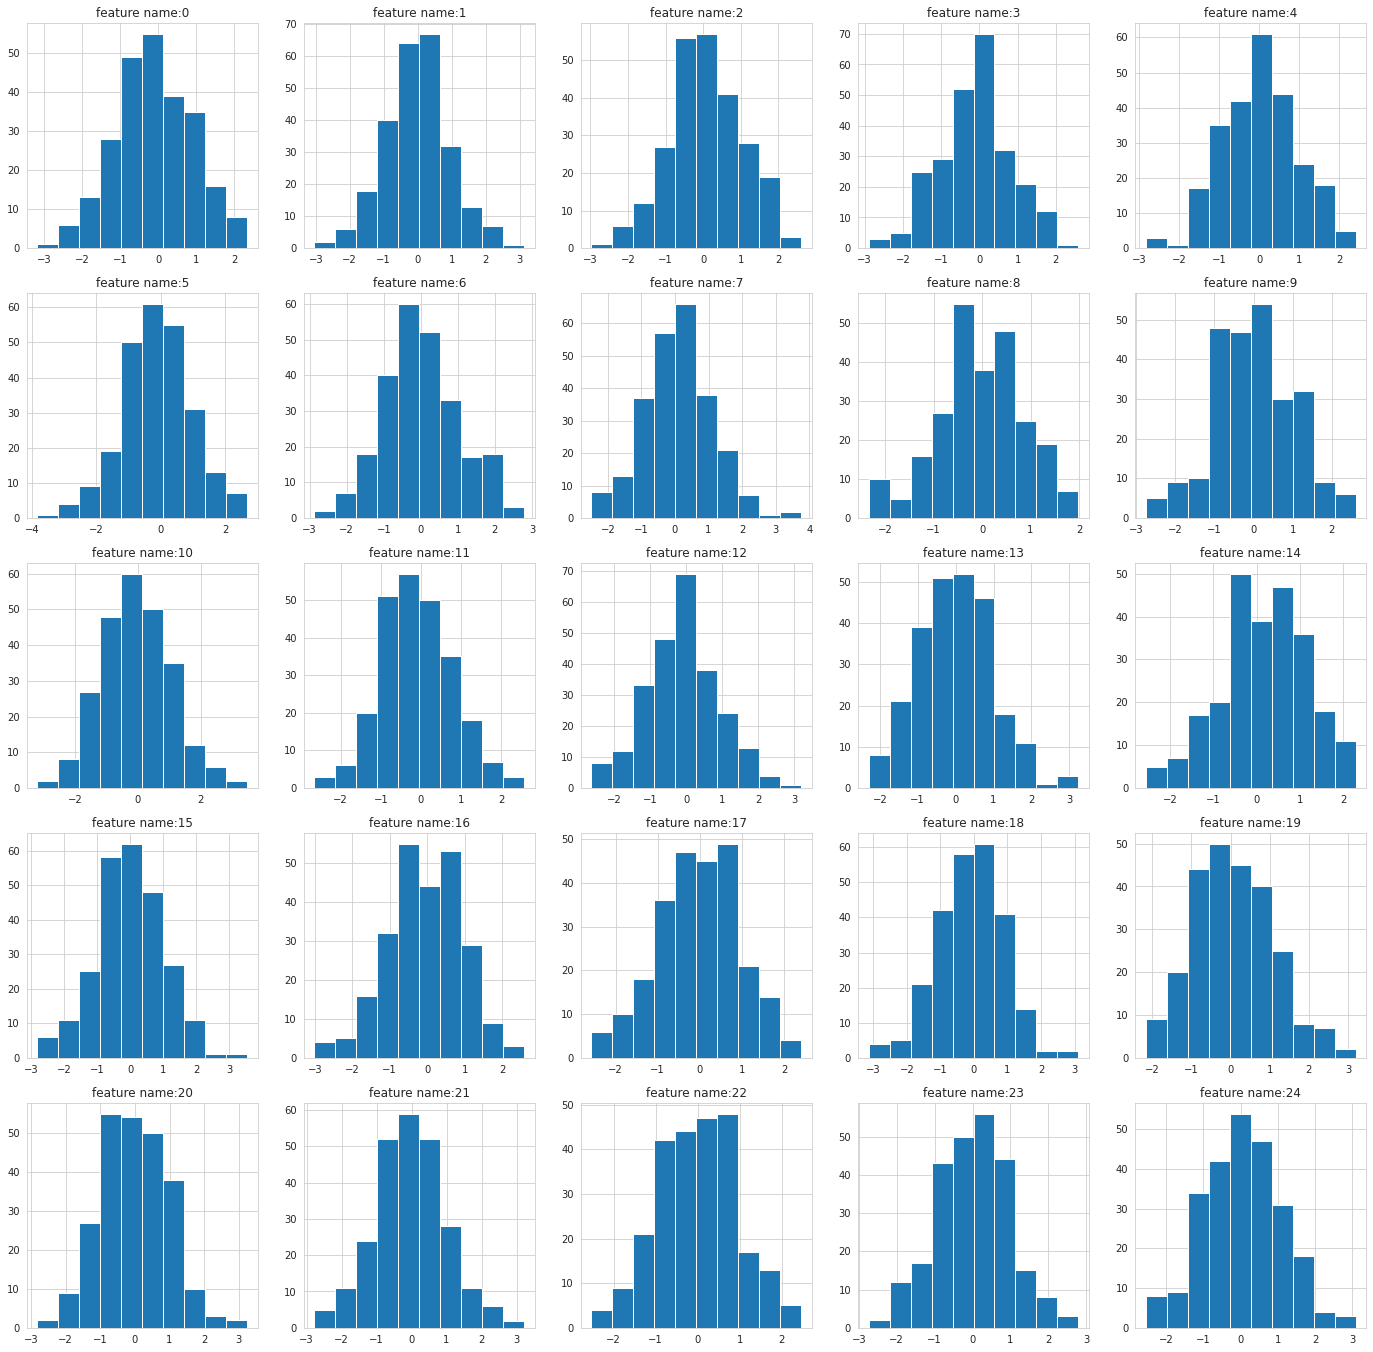

In [80]:
plt.figure(figsize=(24, 24))

for i, feature in enumerate(list(train.columns)[2:27]):
    plt.subplot(5, 5, i + 1)
    plt.hist(train[feature])
    plt.title(f'feature name:{feature}')

From above plots, looks like it's safe to assume all 302 cols/features are normally distributed.

<AxesSubplot:xlabel='target', ylabel='count'>

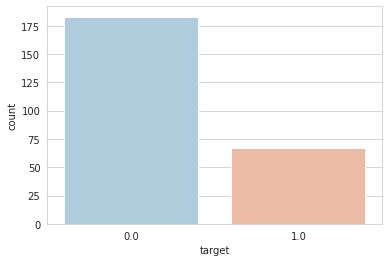

In [81]:
import seaborn as sns
sns.set_style('whitegrid')
sns.countplot(x='target',data=train, palette='RdBu_r')

## Data Imbalance
From the Histogram above, we have data imbalance. Apply SMOTE later?v Does not look at bad though, ratio of ~ 3:1

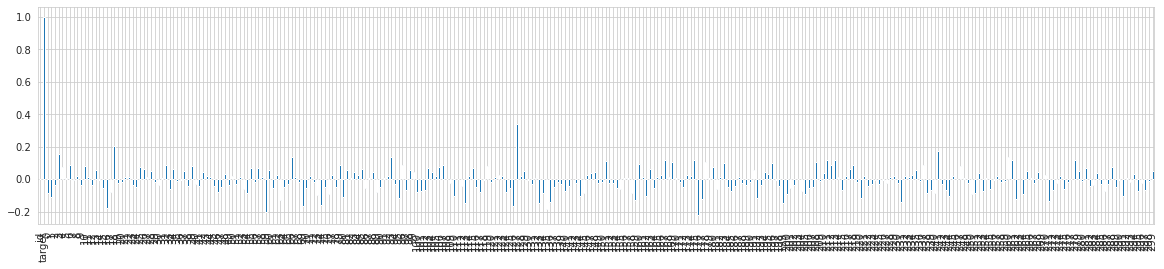

In [83]:
train.corr()['target'].plot(kind='bar', style='k--', label='Series', grid=True, figsize=(20, 4)) 
corr = train.corr()['target']

In [84]:
corr_df = corr.to_frame()
# selecting only corr() that are greater than 0.2
corr_df[corr_df['target'] > 0.2] 

,target
target,1.000000
18,0.206452
127,0.337540


Feature 18 and 128 seemed to be highly correlated with the target label.

## Baseline Model buildling

In [85]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,classification_report,roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn import preprocessing

X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
n_fold = 20
folds = model_selection.StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = model_selection.RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

from sklearn.model_selection import train_test_split
train_x,valid_x,train_y,valid_y = train_test_split(X_train, y_train, random_state = 96, stratify=y_train)

# do not also scale the X_test else you'll leak the scaling info to your test/hold-out set
scaler = preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)

In [86]:
#Model train and eval function
def model_train_eval(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):
    
    algorithm.fit(dtrain_X, dtrain_Y)
    predictions = algorithm.predict(dtest_X)
    print (algorithm)
    # embed()
    print ("ROC-AUC score : ", roc_auc_score(dtest_Y, predictions))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    prediction_probabilities = algorithm.predict_proba(dtest_X)[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    return roc_auc_score(dtest_Y, predictions)

In [87]:
# A lot of people are using logreg currently, let's try
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model_train_eval(model,train_x,train_y,valid_x,valid_y)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
ROC-AUC score :  0.7269820971867008
classification report :
               precision    recall  f1-score   support

         0.0       0.63      0.91      0.74        32
         1.0       0.82      0.45      0.58        31

    accuracy                           0.68        63
   macro avg       0.73      0.68      0.66        63
weighted avg       0.73      0.68      0.66        63



0.7269820971867008

In [88]:
from sklearn.model_selection import learning_curve

def plot_training_curves(X_train, y_train, model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                               X=X_train,
                                               y=y_train,
                                               train_sizes=np.linspace(0.1, 1.0, 10),
                                               cv=10,
                                               n_jobs=1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    train_mean
    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='Training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='Validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.4, 0.9])
    plt.tight_layout()
    # plt.savefig('images/06_05.png', dpi=300)
    plt.show()

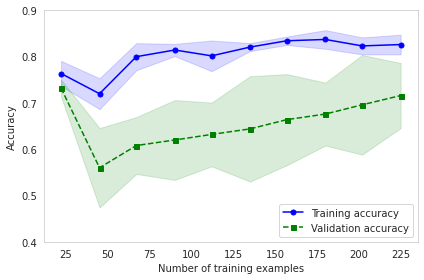

In [89]:
plot_training_curves(X_train, y_train, model)

Looks like pretty big gap - still Overfitting.

## ELI5 (top scoring notebooks use this fancy lib)
Will help to identify useful features. We are overfitting because we have way too many features, which makes are model more complicated. To mitigate overfitting, let's try to less complicate things via feature selection and lowering the feature dimension space.

In [90]:
# ! pip install eli5
import eli5
from eli5 import show_weights

show_weights(model, top=50)

Weight?,Feature
+0.461,x127
+0.223,x18
+0.096,x241
+0.095,x66
+0.060,x93
+0.047,x260
+0.036,x77
+0.029,x175
+0.016,x210
+0.015,x103


In [91]:
eli5.formatters.as_dataframe.explain_weights_df(model)['feature']

0       x127
1        x18
2       x241
3        x66
4        x93
5       x260
6        x77
7       x175
8       x210
9       x103
10      x211
11      x113
12    <BIAS>
13      x192
14       x70
15      x244
16      x267
17      x126
18       x16
19        x1
20       x95
21       x59
22      x239
23      x133
24       x17
25      x189
26      x136
27      x159
28       x80
29       x69
30      x135
31      x199
32       x74
33      x176
Name: feature, dtype: object

In [92]:
top_features = [col[1:] for col in eli5.formatters.as_dataframe.explain_weights_df(model)['feature'] 
                if 'BIAS' not in col]

In [93]:
print(f"There are {len(top_features)} top features")

There are 33 top features


In [94]:
# used ELI5 to simplify the feature space and we ended up with only 33 top features.
X_train = train[top_features]
X_test = test[top_features]

train_x,valid_x,train_y,valid_y = train_test_split(X_train, y_train, random_state = 96, stratify=y_train)

# do not also scale the X_test else you'll leak the scaling info to your test/hold-out set
scaler = preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
valid_x = scaler.transform(valid_x)

In [95]:
# A lot of people are using logreg currently, let's try
model = LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
model_train_eval(model, X_train,y_train,valid_x,valid_y)

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')
ROC-AUC score :  0.8695652173913043
classification report :
               precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        34
         1.0       1.00      0.59      0.74        29

    accuracy                           0.81        63
   macro avg       0.87      0.79      0.79        63
weighted avg       0.86      0.81      0.80        63



0.8695652173913043

In [100]:
X_test.head()

,127,18,241,66,93,260,77,175,210,103,...,17,189,136,159,80,69,135,199,74,176
0,0.876,-0.240,-0.965,0.325,0.243,0.188,0.515,0.082,-0.477,-2.268,...,1.263,1.478,0.598,0.846,0.275,-0.070,-0.818,-1.129,0.974,-0.229
1,0.065,0.095,0.474,-2.332,-0.107,0.513,-2.345,0.760,-0.594,1.574,...,0.686,0.018,-1.526,0.608,1.121,-1.634,-0.421,-0.357,1.016,-0.291
2,0.483,-1.010,0.536,-0.040,-0.376,0.174,1.777,-1.291,1.555,-0.420,...,-0.852,2.182,-2.042,-1.744,1.249,-1.541,1.567,-0.138,-0.527,0.048
3,-0.354,2.246,1.263,-0.044,0.839,0.554,-0.743,0.815,0.250,-0.678,...,0.277,-0.401,0.392,-0.760,2.195,-0.099,0.549,0.015,-0.021,-1.209
4,-0.328,1.628,0.941,1.439,1.441,0.017,0.587,0.330,-1.246,0.180,...,-0.378,-0.854,0.656,1.545,-2.052,0.335,0.656,-1.554,-0.446,-0.410


In [97]:
! pwd

/kaggle/working


In [101]:
def save_submission_file(model, filename="submission.csv"):
    # holdout_data = X_test.drop(['id'], axis=1)
    holdout_data = X_test
    predictions = model.predict(holdout_data)
    
    holdout_ids = test["id"]
    submission_df = {"id": holdout_ids,
                 "target": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(os.path.join('/kaggle/working',filename),index=False)
    return submission

save_submission_file(model)

,id,target
0,250,1.0
1,251,1.0
2,252,1.0
3,253,1.0
4,254,1.0
...,...,...
19745,19995,0.0
19746,19996,1.0
19747,19997,1.0
19748,19998,1.0


In [ ]:
! ls